In [ ]:
# is needed for correct working
!pip install -U scipy

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import math
from sklearn.neighbors import KernelDensity
from scipy.stats import norm, gamma, expon

In [3]:
# data import

car_sales = pd.read_csv(filepath_or_buffer='/content/drive/MyDrive/Car_Sales.csv', sep=',')
del car_sales['Unnamed: 0']
car_sales

,Manufacturer,Model,Sales_in_thousands,Year_resale_value,Vehicle_type,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_perf_factor,Country,Tax_type
0,Acura,Integra,16.919,16.360,Passenger,21.50,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,2/2/2012,58.280150,Japan,2.0
1,Acura,TL,39.384,19.875,Passenger,28.40,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,6/3/2011,91.370778,Japan,5.0
2,Acura,CL,14.114,18.225,Passenger,30.60,3.2,225.0,106.9,70.6,192.0,3.470,17.2,26.0,1/4/2012,91.361224,Japan,5.0
3,Acura,RL,8.588,29.725,Passenger,42.00,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,3/10/2011,91.389779,Japan,5.0
4,Audi,A4,20.397,22.255,Passenger,23.99,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,10/8/2011,62.777639,Germany,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,Volvo,V40,3.545,NaN,Passenger,24.40,1.9,160.0,100.5,67.6,176.6,3.042,15.8,25.0,9/21/2011,66.498812,Sweden,3.0
152,Volvo,S70,15.245,NaN,Passenger,27.50,2.4,168.0,104.9,69.3,185.9,3.208,17.9,25.0,11/24/2012,70.654495,Sweden,3.0
153,Volvo,V70,17.531,NaN,Passenger,28.80,2.4,168.0,104.9,69.3,186.2,3.259,17.9,25.0,6/25/2011,71.155978,Sweden,3.0
154,Volvo,C70,3.493,NaN,Passenger,45.50,2.3,236.0,104.9,71.5,185.7,3.601,18.5,23.0,4/26/2011,101.623357,Sweden,6.0


**FUNCTIONS**

In [4]:
#Kernel Density Estimation

def kde(feature):
    
    column = feature

    model = KernelDensity(bandwidth=2, kernel='gaussian')
    column = column.values.reshape((len(column), 1))
    model.fit(column)

    min, max = feature.min(), feature.max()
    values = np.asarray([value for value in range(int(min), int(max))])
    values = values.reshape((len(values), 1))
    probabilities = model.score_samples(values)
    probabilities = np.exp(probabilities)
    
    sns.set_theme()
    sns.histplot(feature, kde=False, bins=int(5 * math.log(len(feature.index))), stat='density')
    plt.plot(values[:], probabilities, color='red')

In [5]:
# Cutting ends

def cut_ends(feature):

  q_1, q_3 = np.percentile(feature, [25, 75])
  dfce = q_3 - q_1
  bottom_border, top_border = q_1 - 1.5*dfce, q_3 + 1.5*dfce
  feature = feature[feature > bottom_border]
  feature = feature[feature < top_border]

  return feature

In [6]:
# Calculating order statistics

def order_stats(param, name):

  var = param.var()
  median = None
  
  print('Variance = ' + str(round(var,2)))
  
  if type(param) == type(np.array([])):
    median = np.median(param)
  else:
    median = param.median()

  print('Median = ' + str(round(median,2)))


  def mad(df):
    
    sigma = 1.2
    k = scipy.stats.lognorm.ppf(3/4., s=sigma)
    
    return k * np.median(np.fabs(df - median))


  mad = mad(param)
  print('MAD = ' + str(round(mad,2)))

  truncated_mean = scipy.stats.trim_mean(param, proportiontocut=0.1)
  print('Trancated Mean = ' + str(round(truncated_mean,2)))

  print(param.describe())

  sns.set_theme()
  sns.set(rc={'figure.figsize':(10,6)})
  ax = sns.boxplot(x=param)
  ax.set(xlabel=name)

In [7]:
# Estimation Parameters, using Least-Squares and Maximum Likelyhood

def param_estimation(feature, distribution, start_point):

  def least_squares(x_arr, y_arr, pdf):
    return np.sum((pdf(x_arr) - y_arr) ** 2)

  def distr_func(x_arr, pdf):
    return pdf(x_arr)

  n_bins = int(5 * math.log(len(feature.index)))
  hist, borders = np.histogram(feature, bins=n_bins, density=True)
  borders += (borders[0] - borders[1]) / 2
  borders = borders[1:]

  opt_func = lambda args: least_squares(borders, hist, distribution(*args).pdf)
  ls_params = scipy.optimize.minimize(opt_func, start_point, method="nelder-mead", options={'disp': True, 'maxiter': 2000})

  ml_params = distribution.fit(feature)

  print('LS parameters: ' + str(ls_params.x))
  print('ML parameters: ' + str(ml_params))
  
  distr_val = lambda args: distr_func(borders, distribution(*args).pdf)

  sns.set_theme()
  sns.histplot(feature, kde=False, bins=n_bins, stat='density')
  plt.plot(borders, distr_val(list(ls_params.x)), color='red', label='Least Squares')
  plt.plot(borders, distr_val(list(ml_params)), color='green', label='Maximum Likelyhood')
  plt.legend()

  return ml_params

In [8]:
# QQ-biplot

def qq_plot(feature, distribution):

  percs = np.linspace(0, 100, 100)
  x = np.linspace(np.min(feature), np.max(feature))
  qn_first = np.percentile(feature, percs)
  qn_norm = distribution.ppf(percs / 100.0, *params)

  plt.figure(figsize=(6, 6))
  plt.scatter(qn_first, qn_norm)
  plt.plot(x, x, color="k", ls="--")
  plt.xlabel('Empirical distribution')
  plt.ylabel('Theoretical distribution')

  plt.show()

In [9]:
# Statistical tests

def statistical_tests(feature, distr):

  ks = scipy.stats.kstest(feature, distr, params)
  cv = scipy.stats.cramervonmises(feature, distr, params)
  print(ks)
  print(cv)

**RESULTS**

**Sales in thousands**

In [10]:
feature = car_sales.Sales_in_thousands
feature = cut_ends(feature)

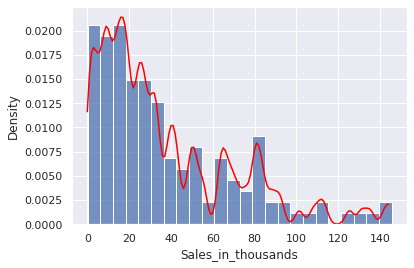

In [11]:
kde(feature)

Variance = 4657.86
Median = 29.21
MAD = 45.47
Trancated Mean = 39.28
count    156.000000
mean      52.994987
std       68.248508
min        0.110000
25%       14.035000
50%       29.213000
75%       68.069750
max      540.561000
Name: Sales_in_thousands, dtype: float64


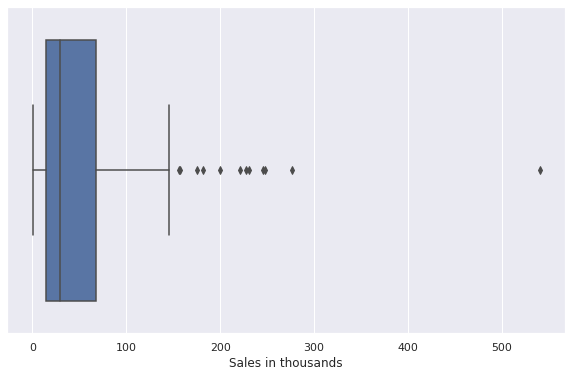

In [12]:
order_stats(car_sales.Sales_in_thousands, 'Sales in thousands')

Optimization terminated successfully.
         Current function value: 0.000096
         Iterations: 81
         Function evaluations: 155
LS parameters: [ 1.54411093 42.28605072]
ML parameters: (0.11, 37.442479166666665)


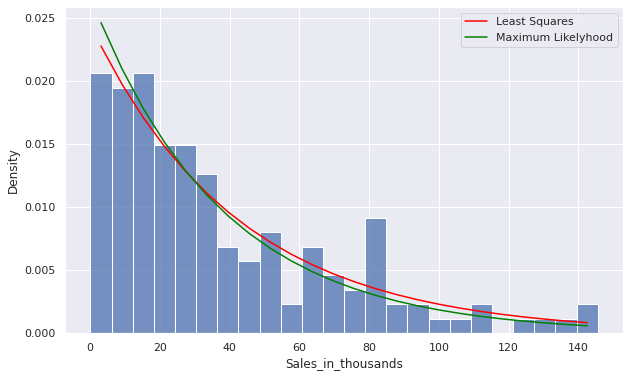

In [13]:
params = param_estimation(feature, expon, [10,10])

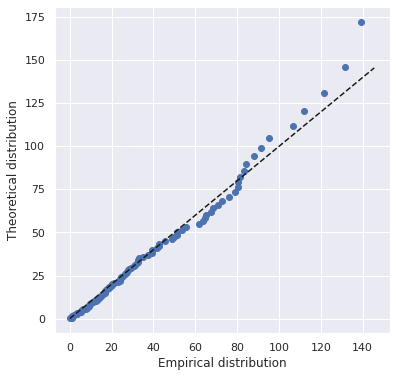

In [14]:
qq_plot(feature, expon)

In [15]:
statistical_tests(feature, 'expon')

KstestResult(statistic=0.05166652901525137, pvalue=0.8174933673728284)
CramerVonMisesResult(statistic=0.06347952507739697, pvalue=0.7928784272462693)


**Price in thousands**

In [16]:
feature = car_sales.Price_in_thousands

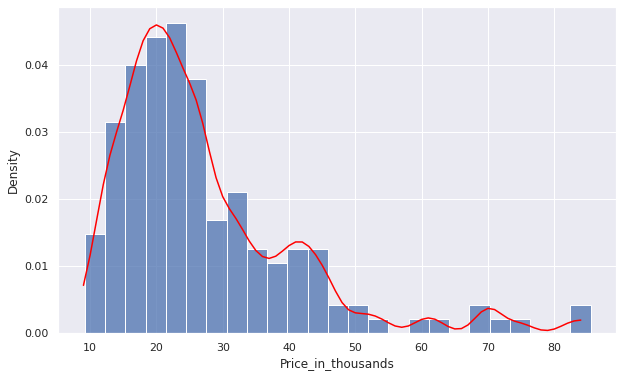

In [17]:
kde(feature)

Variance = 204.71
Median = 23.1
MAD = 13.97
Trancated Mean = 25.25
count    156.000000
mean      27.411327
std       14.307590
min        9.235000
25%       18.081250
50%       23.099500
75%       31.938750
max       85.500000
Name: Price_in_thousands, dtype: float64


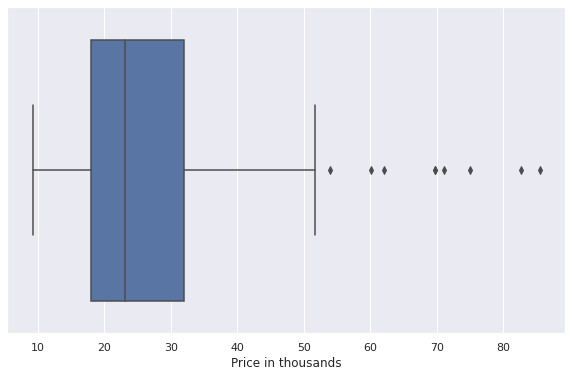

In [18]:
order_stats(car_sales.Price_in_thousands, 'Price in thousands')

Optimization terminated successfully.
         Current function value: 0.000308
         Iterations: 213
         Function evaluations: 384
LS parameters: [2.55284603 8.32691872 6.83528759]
ML parameters: (1.9217325289221034, 8.829406276244782, 9.669407924596563)


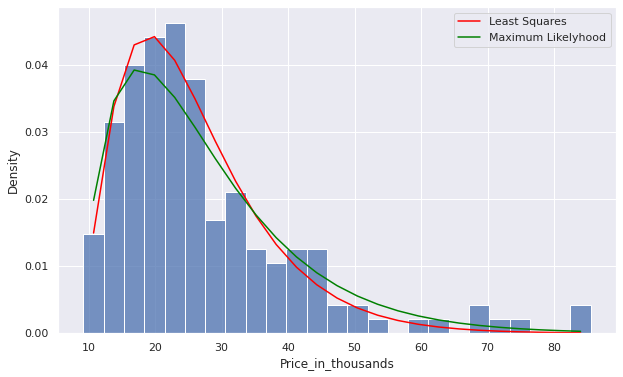

In [19]:
params = param_estimation(feature, gamma, [10,10,10])

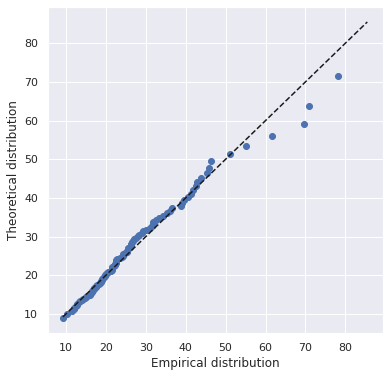

In [20]:
qq_plot(feature, gamma)

In [21]:
statistical_tests(feature, 'gamma')

KstestResult(statistic=0.06371173328809498, pvalue=0.53002809935236)
CramerVonMisesResult(statistic=0.1038819876170988, pvalue=0.566738687239747)


**Wheelbase**

In [22]:
feature = car_sales.Wheelbase
feature = cut_ends(feature)

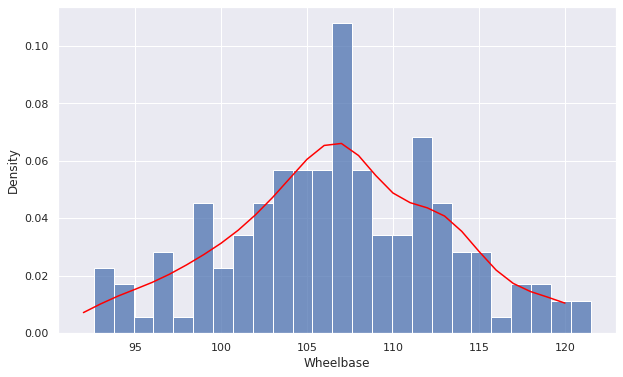

In [23]:
kde(feature)

Variance = 58.39
Median = 107.0
MAD = 10.33
Trancated Mean = 107.11
count    156.000000
mean     107.487179
std        7.641303
min       92.600000
25%      103.000000
50%      107.000000
75%      112.200000
max      138.700000
Name: Wheelbase, dtype: float64


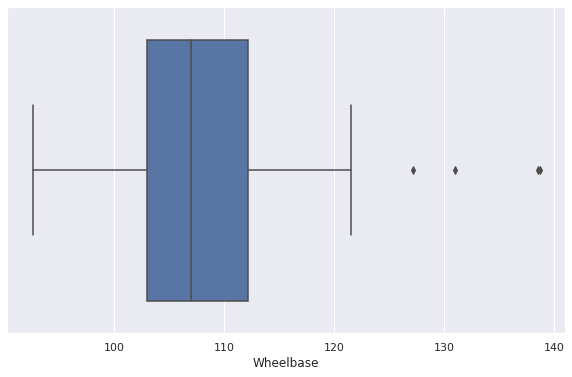

In [24]:
order_stats(car_sales.Wheelbase, 'Wheelbase')

Optimization terminated successfully.
         Current function value: 0.005198
         Iterations: 72
         Function evaluations: 136
LS parameters: [106.84371121   6.32093278]
ML parameters: (106.79342105263157, 6.334810584264075)


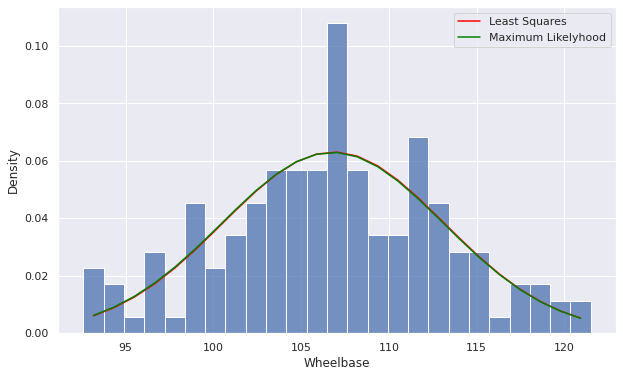

In [25]:
params = param_estimation(feature, norm, [10,10])

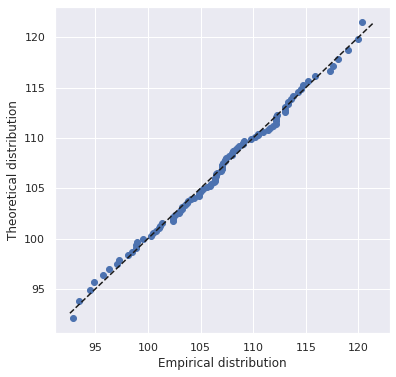

In [26]:
qq_plot(feature, norm)

In [27]:
statistical_tests(feature, 'norm')

KstestResult(statistic=0.049184862797380824, pvalue=0.837809570153052)
CramerVonMisesResult(statistic=0.05831167247414826, pvalue=0.8253567245479301)
